In [1]:
from google.colab import drive
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/dataset/split_dataset.zip'
zip_ref   = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
TRAINING_PATH = '/content/split_dataset/train/'
VALIDATION_PATH = '/content/split_dataset/val/'

In [5]:
train_bika_ambon_path = os.path.join(TRAINING_PATH, 'bika_ambon')
train_serabi_path = os.path.join(TRAINING_PATH, 'serabi')
validation_bika_path = os.path.join(VALIDATION_PATH, 'bika_ambon')
validation_serabi_path = os.path.join(VALIDATION_PATH, 'serabi')

In [6]:
train_bika = os.listdir(train_bika_ambon_path)
print(train_bika[:10])

train_serabi = os.listdir(train_serabi_path)
print(train_serabi[:10])

validation_bika = os.listdir(validation_bika_path)
print(validation_bika[:10])

validation_serabi = os.listdir(validation_serabi_path)
print(validation_serabi[:10])

['bika_ambon_00000165.jpg', 'bika_ambon_00000085.jpg', 'bika_ambon_00000030.jpg', 'bika_ambon_00000109.jpg', 'bika_ambon_00000089.jpg', 'bika_ambon_00000128.jpg', 'bika_ambon_00000133.jpg', 'bika_ambon_00000082.jpg', 'bika_ambon_00000159.jpg', 'bika_ambon_00000195.jpg']
['serabi_00000002.jpg', 'serabi_00000144.jpg', 'serabi_00000243.jpg', 'serabi_00000149.jpg', 'serabi_00000132.jpg', 'serabi_00000036.jpg', 'serabi_00000104.jpg', 'serabi_00000126.jpg', 'serabi_00000046.jpg', 'serabi_00000120.jpg']
['bika_ambon_00000001.jpg', 'bika_ambon_00000135.jpg', 'bika_ambon_00000068.jpg', 'bika_ambon_00000023.jpg', 'bika_ambon_00000217.jpg', 'bika_ambon_00000246.jpg', 'bika_ambon_00000166.jpg', 'bika_ambon_00000257.jpg', 'bika_ambon_00000007.jpg', 'bika_ambon_00000199.jpg']
['serabi_00000163.jpg', 'serabi_00000109.jpg', 'serabi_00000001.jpg', 'serabi_00000151.jpg', 'serabi_00000050.jpg', 'serabi_00000181.jpg', 'serabi_00000110.jpg', 'serabi_00000229.jpg', 'serabi_00000237.jpg', 'serabi_00000088.jp

In [7]:
%matplotlib inline
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

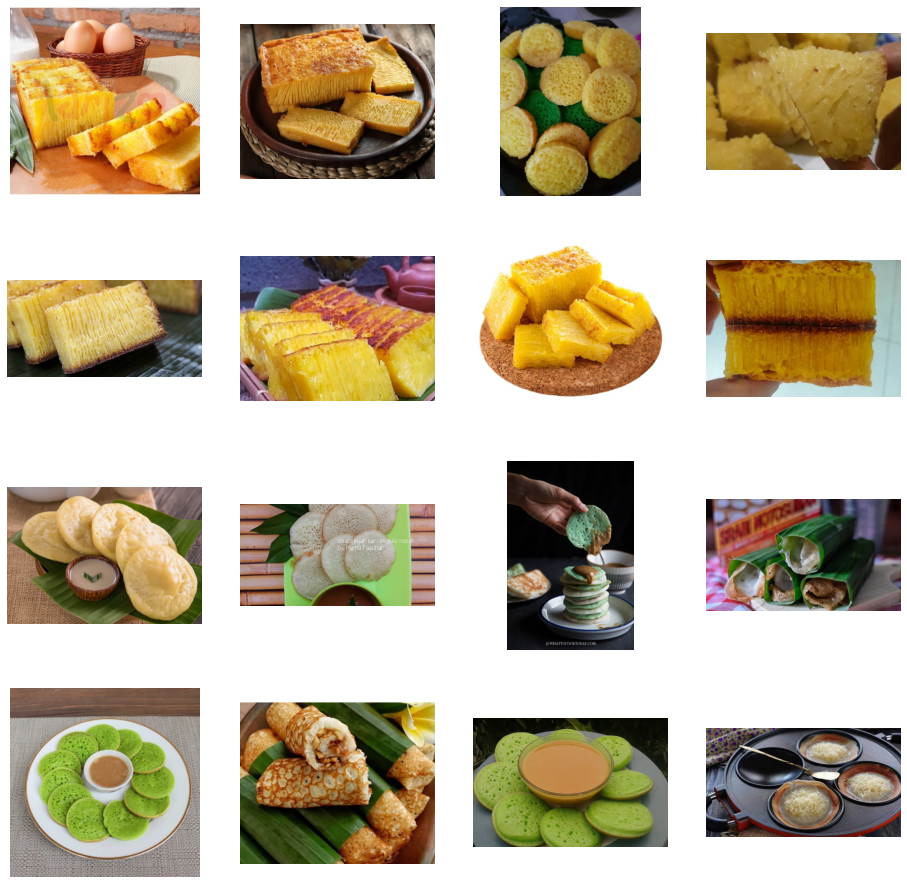

In [8]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_paper_pic = [os.path.join(train_bika_ambon_path, fname) 
                for fname in train_bika[pic_index-8:pic_index]]
next_plastic_pic = [os.path.join(train_serabi_path, fname) 
                for fname in train_serabi[pic_index-8:pic_index]]

for i, img_path in enumerate(next_paper_pic + next_plastic_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [12]:
def train_val_generators(TRAINING_PATH, VALIDATION_PATH):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range = 40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    train_generator = train_datagen.flow_from_directory(TRAINING_PATH,
                                                        target_size=(150, 150),
                                                        class_mode='categorical',
                                                        batch_size=64
                                                        )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
                                                                VALIDATION_PATH,
                                                                target_size=(150, 150),
                                                                class_mode='categorical',
                                                                batch_size=64
                                                                )

    return train_generator, validation_generator

In [13]:
train_generator, validation_generator = train_val_generators(TRAINING_PATH, VALIDATION_PATH)

Found 2139 images belonging to 15 classes.
Found 542 images belonging to 15 classes.


# Pre-Trained Inception

In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [14]:
base_model = InceptionV3(input_shape= (150, 150, 3), include_top=False, weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(15, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [18]:
from tensorflow.keras.optimizers import RMSprop
optimizers = RMSprop(learning_rate= 0.001)
model.compile(optimizer= optimizers,
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

In [19]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 20
                    #callbacks = callbacks
                    )

Epoch 1/20
34/34 [==============================] - 54s 1s/step - loss: 65.8289 - accuracy: 0.2398 - val_loss: 3.4833 - val_accuracy: 0.4391
Epoch 2/20
34/34 [==============================] - 38s 1s/step - loss: 3.3871 - accuracy: 0.3506 - val_loss: 3.0941 - val_accuracy: 0.3321
Epoch 3/20
34/34 [==============================] - 36s 1s/step - loss: 2.8591 - accuracy: 0.3567 - val_loss: 1.5199 - val_accuracy: 0.5664
Epoch 4/20
34/34 [==============================] - 36s 1s/step - loss: 2.2694 - accuracy: 0.4563 - val_loss: 2.5152 - val_accuracy: 0.4022
Epoch 5/20
34/34 [==============================] - 36s 1s/step - loss: 1.7724 - accuracy: 0.5203 - val_loss: 1.3255 - val_accuracy: 0.6162
Epoch 6/20
34/34 [==============================] - 36s 1s/step - loss: 1.6933 - accuracy: 0.5278 - val_loss: 1.3185 - val_accuracy: 0.6125
Epoch 7/20
34/34 [==============================] - 36s 1s/step - loss: 1.6263 - accuracy: 0.5423 - val_loss: 1.1673 - val_accuracy: 0.6292
Epoch 8/20
34/34 [=

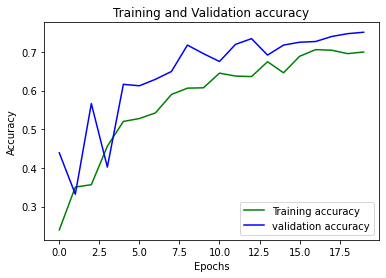

In [20]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(20)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

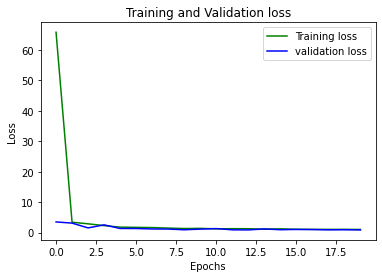

In [21]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(20)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
labels = ['bika_ambon', 'gudeg', 'gulai_ayam', 'kerak_telor', 'klepon', 'martabak', 'nasi_tumpeng', 'pecel', 'pempek', 'rawon', 'rendang', 'sate', 'serabi', 'soto_ayam', 'tahu_gejrot']
food= {}

for i in range(len(labels)):
    food[labels[i]] = i
food

{'bika_ambon': 0,
 'gudeg': 1,
 'gulai_ayam': 2,
 'kerak_telor': 3,
 'klepon': 4,
 'martabak': 5,
 'nasi_tumpeng': 6,
 'pecel': 7,
 'pempek': 8,
 'rawon': 9,
 'rendang': 10,
 'sate': 11,
 'serabi': 12,
 'soto_ayam': 13,
 'tahu_gejrot': 14}

In [23]:
pred = model.predict(validation_generator)

In [26]:
pred.shape

(542, 15)

In [27]:
pred[212]

array([6.8345559e-03, 4.5185974e-03, 2.1669111e-01, 1.5487618e-05,
       1.7553593e-06, 9.9606252e-05, 2.7311873e-05, 2.1518438e-06,
       3.0659754e-02, 5.0741324e-05, 1.3926445e-04, 7.4714380e-06,
       6.0121121e-05, 8.7322434e-04, 7.4001890e-01], dtype=float32)

TypeError: ignored

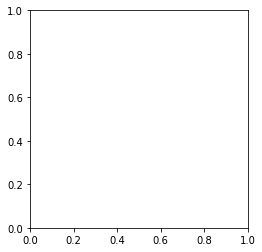

In [30]:
plt.figure()
plt.imshow(pred[212])
plt.colorbar()
plt.show()

In [24]:
from imutils import paths
path_test = []
for imagePath in paths.list_images(VALIDATION_PATH):
    path_test.append(os.path.join(VALIDATION_PATH, imagePath))

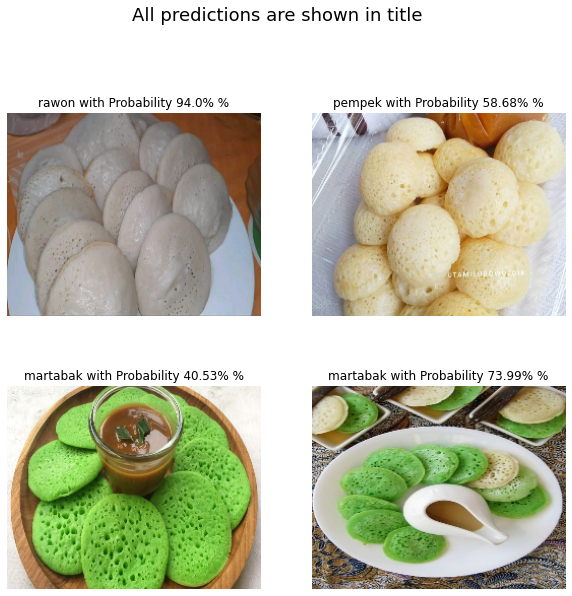

In [25]:
fig, axs= plt.subplots(2,2, figsize=[10,10])
fig.subplots_adjust(hspace=.01)


count=0
for i in range(2):    
    for j in range(2):  
        
        img = cv2.imread(path_test[count])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, (250,200))
        result = np.argsort(pred[count])[::-1]
        
        i_max = -1
        max_val = ""
        for (k,val) in enumerate(food.keys()):
            
            if(pred[count][k] > i_max):
                i_max = pred[count][k]
                max_val = val
        
        txt = str(max_val) + " with Probability "+ str("{:.4}%".format(i_max*100)) + " %"
            
        
        axs[i][j].imshow(img)
        axs[i][j].set_title(txt)
        axs[i][j].axis('off')

        count+=1
        
plt.suptitle("All predictions are shown in title", fontsize = 18)        
plt.show()